In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    plot_confusion_matrix,
    classification_report,
)
import xgboost as xgb

from pathlib import Path
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV

In [85]:
data_path = Path.cwd() / "../data"
df_train = pd.read_csv(data_path / "df_train.csv", index_col=0)
df_val = pd.read_csv(data_path / "df_val.csv", index_col=0)

In [86]:
df_train['y'] = df_train.account_status.map({'open': 0, 'closed': 1})
df_val['y'] = df_val.account_status.map({'open': 0, 'closed': 1})
df_train = df_train.drop('account_status', axis=1)
df_val = df_val.drop('account_status', axis=1)

In [87]:
X_train = df_train.drop('y', axis=1)
y_train = df_train['y']
X_val = df_val.drop('y', axis=1)
y_val = df_val['y']

In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 4693 to 3582
Data columns (total 41 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   customer_age                                7588 non-null   float64
 1   customer_sex                                7278 non-null   object 
 2   customer_number_of_dependents               8101 non-null   int64  
 3   customer_education                          8101 non-null   object 
 4   customer_civil_status                       8101 non-null   object 
 5   customer_salary_range                       7561 non-null   object 
 6   customer_relationship_length                8101 non-null   int64  
 7   customer_available_credit_limit             8101 non-null   float64
 8   credit_card_classification                  8101 non-null   object 
 9   total_products                              8101 non-null   int64  
 10  period_inactiv

In [89]:
df_train.isna().sum()

customer_age                                  513
customer_sex                                  823
customer_number_of_dependents                   0
customer_education                              0
customer_civil_status                           0
customer_salary_range                         540
customer_relationship_length                    0
customer_available_credit_limit                 0
credit_card_classification                      0
total_products                                  0
period_inactive                                 0
contacts_in_last_year                           0
credit_card_debt_balance                        0
remaining_credit_limit                          0
transaction_amount_ratio                        0
total_transaction_amount                      315
total_transaction_count                         0
transaction_count_ratio                         0
average_utilization                             0
customer_available_credit_limit_below_1450      0


In [90]:
df_train.describe()

,customer_age,customer_number_of_dependents,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,credit_card_debt_balance,remaining_credit_limit,transaction_amount_ratio,...,total_transaction_count_51_100,total_transaction_count_more_than_100,transaction_count_ratio_0_05,transaction_count_ratio_05_1,transaction_count_ratio_1_2,transaction_count_ratio_more_than_2,average_utilization_0_02,average_utilization_02_06,average_utilization_more_than_06,y
count,7588.000000,8101.000000,8101.00000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,...,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.00000
mean,46.251713,2.350574,35.83323,8.646666,4.140600,2.341810,2.445254,1174.211455,8.158414,0.759760,...,0.626836,0.064683,0.145167,0.752747,0.063696,0.038390,0.522898,0.298605,0.178496,0.15998
std,8.048139,1.299210,8.03008,0.978194,3.130078,1.016562,1.099662,813.533813,1.307758,0.216344,...,0.483675,0.245982,0.352291,0.431442,0.244225,0.192149,0.499506,0.457675,0.382954,0.36661
min,26.000000,0.000000,13.00000,7.271217,1.000000,0.000000,0.000000,0.000000,1.098612,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,41.000000,1.000000,31.00000,7.858641,3.000000,2.000000,2.000000,493.000000,7.188413,0.631000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,46.000000,2.000000,36.00000,8.457443,4.000000,2.000000,2.000000,1291.000000,8.153925,0.737000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000
75%,52.000000,3.000000,40.00000,9.360225,5.000000,3.000000,3.000000,1791.000000,9.182044,0.857000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000
max,73.000000,5.000000,56.00000,12.646403,36.000000,6.000000,6.000000,2517.000000,10.449178,3.397000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


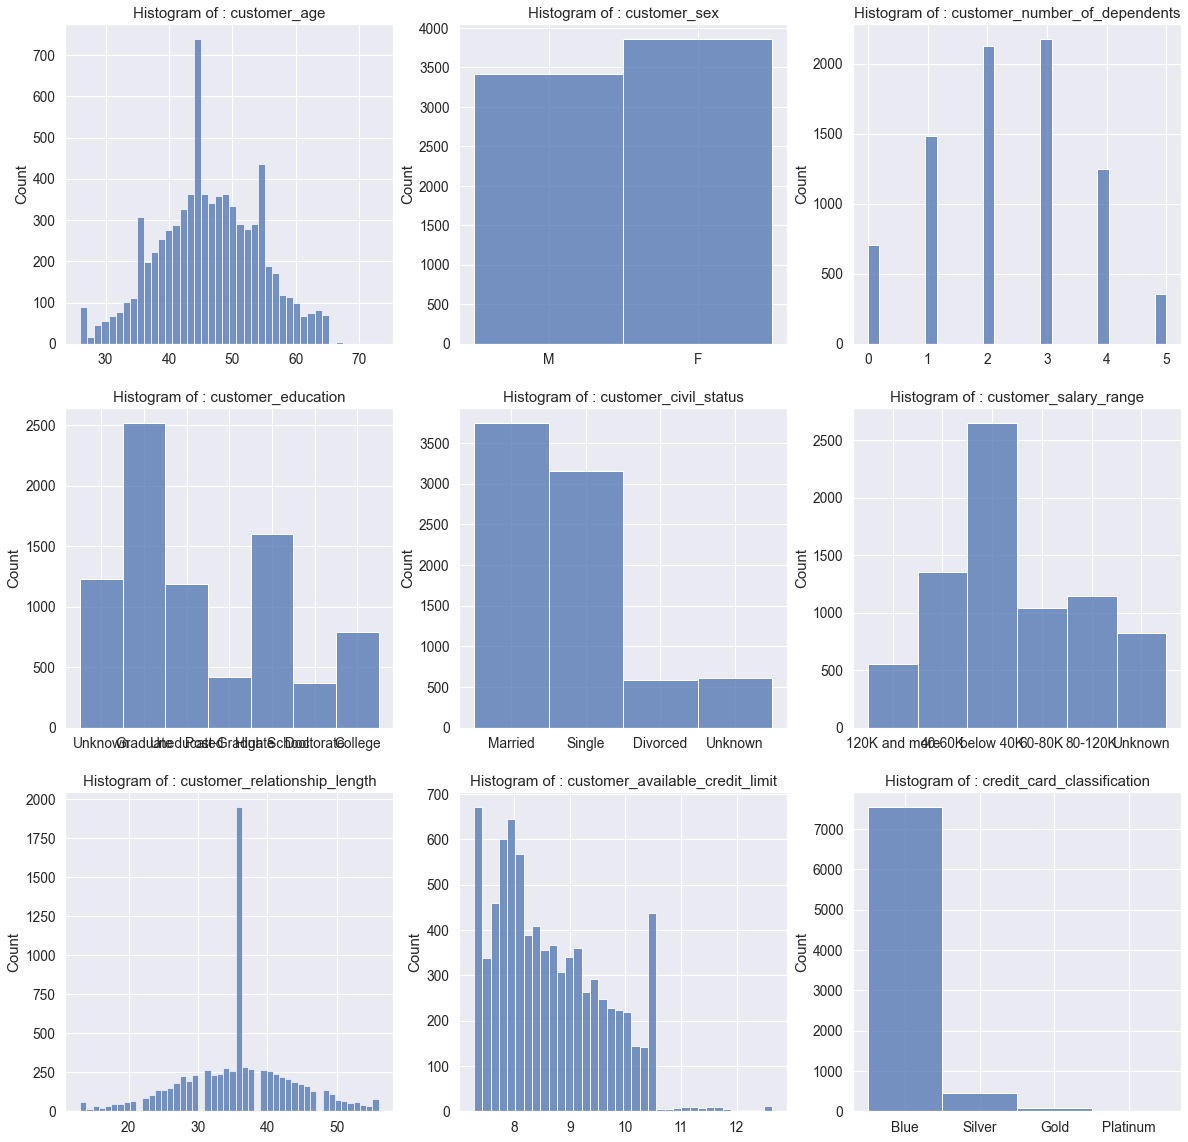

In [56]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
for i, ax in zip(df_train.columns, axes.flat):
    sns.histplot(x=df_train[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

In [91]:
X_train.replace('Unknown', np.NaN, inplace=True)
X_val.replace('Unknown', np.NaN, inplace=True)

In [92]:
X_train['customer_sex'] = np.where(X_train['customer_sex'] == 'F', 1, 0)
X_val['customer_sex'] = np.where(X_val['customer_sex'] == 'F', 1, 0)

In [93]:
from category_encoders import OrdinalEncoder
mapping = [{'col': 'customer_salary_range', 'mapping': {"below 40K": 1,  "40-60K": 2, "60-80K": 3, "80-120K": 4, "120K and more": 5}}]
oe = OrdinalEncoder(cols=['customer_salary_range'], mapping=mapping)
oe.fit(X_train)
X_train = oe.transform(X_train)
X_val = oe.transform(X_val)

In [94]:
cols_to_be_encoded = ['customer_education', 'customer_civil_status', 'credit_card_classification']
from category_encoders import OneHotEncoder
ohe = OneHotEncoder(cols=cols_to_be_encoded)
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_val = ohe.transform(X_val)

In [95]:
imputer = KNNImputer(n_neighbors=3)
imputed_train_data = imputer.fit_transform(X_train)
imputed_test_data = imputer.transform(X_val)

X_val = pd.DataFrame(imputed_test_data, columns=X_val.columns)
X_train = pd.DataFrame(imputed_train_data, columns=X_train.columns)

In [96]:
std = StandardScaler()
num_col = ['customer_age',
 'customer_number_of_dependents',
 'customer_relationship_length',
 'customer_available_credit_limit',
 'total_products',
 'period_inactive',
 'contacts_in_last_year',
 'credit_card_debt_balance',
 'remaining_credit_limit',
 'transaction_amount_ratio',
 'total_transaction_amount',
 'total_transaction_count',
 'transaction_count_ratio',
 'average_utilization']
arr = std.fit_transform(X_train[num_col])
arr = pd.DataFrame(arr, columns = num_col)
X_train = X_train.reset_index(drop=True)
X_train.drop(num_col, axis=1, inplace=True)
X_train = pd.concat([X_train, arr], axis=1)

arr1 = std.transform(X_val[num_col])
arr1 = pd.DataFrame(arr1, columns = num_col)
X_val = X_val.reset_index(drop=True)
X_val.drop(num_col, axis=1, inplace=True)
X_val = pd.concat([X_val, arr1], axis=1)

y_train = y_train.reset_index(drop=True)

In [109]:
def random_search(X, y, params, model, n_iter=10, n_splits=5, scoring='balanced_accuracy', seed=42):
    """
    Perform random search with cross-validation.

    Returns:
    results (dict): A dictionary of the results
    """

    # Perform random search with cross-validation
    random_search = RandomizedSearchCV(
        model,
        param_distributions=params,
        n_iter=n_iter,
        scoring=scoring,
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=n_splits),
        random_state=seed,
        verbose=4
    )
    random_search.fit(X, y)

    # Extract and return the results
    results = {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'cv_results': random_search.cv_results_
    }
    return results

In [111]:
scale_pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', scale_pos_weight=scale_pos_weight)

params = {"n_estimators": np.arange(50,800,50),
             "max_depth": np.arange(2,10),
             "learning_rate": np.arange(0.01,0.1,0.02),
             'subsample': np.arange(0.5, 1.0, 0.1),
             'colsample_bytree': np.arange(0.4, 1.0, 0.1),
             'colsample_bylevel': np.arange(0.4, 1.0, 0.1)}

results = random_search(X_train, y_train, params, xgb_model, n_iter=60, n_splits=5, scoring='balanced_accuracy', seed=42)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyError: 'best_estimator_'

In [112]:
best_params = results['best_params']
best_score = results['best_score']

# Train the model with the best hyperparameters
model = xgb.XGBClassifier(**best_params, random_state=42, objective='binary:logistic', eval_metric='aucpr', scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

best_xgb = {}
best_xgb['best_params'] = best_params
best_xgb['best_score'] = best_score
best_xgb['auc'] = auc

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test AUC: {auc}")

Best hyperparameters: {'subsample': 0.7999999999999999, 'n_estimators': 550, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.7}
Best score: 0.9470745230701146
Test AUC: 0.9945868869698509


In [113]:
# Create the Logistic Regression model
logreg_model = LogisticRegression()

params = {
    'C': uniform(0.1, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

results = random_search(X_train, y_train, params, logreg_model, n_iter=10, n_splits=5, scoring='balanced_accuracy', seed=42)

best_params = results['best_params']
best_score = results['best_score']
model = LogisticRegression(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

best_logreg = {}
best_logreg['best_params'] = best_params
best_logreg['best_score'] = best_score
best_logreg['auc'] = auc

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test AUC: {auc}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

Best hyperparameters: {'C': 6.218528947223795, 'max_iter': 500, 'solver': 'saga'}
Best score: 0.7676558067704284
Test AUC: 0.9227887246121078


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [114]:
# Create the KNN model
knn_model = KNeighborsClassifier()

params = {
    'n_neighbors': randint(3, 10),
    'weights': ['uniform', 'distance']
}

results = random_search(X_train, y_train, params, knn_model, n_iter=10, n_splits=5, scoring='balanced_accuracy', seed=42)

best_params = results['best_params']
best_score = results['best_score']

model = KNeighborsClassifier(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

best_knn = {}
best_knn['best_params'] = best_params
best_knn['best_score'] = best_score
best_knn['auc'] = auc

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test AUC: {auc}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'n_neighbors': 5, 'weights': 'distance'}
Best score: 0.7563599864003978
Test AUC: 0.9086026967533798


In [115]:
# Create the Lasso model
lasso_model = Lasso()

params = {
    'alpha': uniform(0.1, 10)
}

results = random_search(X_train, y_train, params, lasso_model, n_iter=10, n_splits=5, scoring='balanced_accuracy', seed=42)

best_params = results['best_params']
best_score = results['best_score']

model = Lasso(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
auc = roc_auc_score(y_val, y_pred)

best_lasso = {}
best_lasso['best_params'] = best_params
best_lasso['best_score'] = best_score
best_lasso['auc'] = auc

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test AUC: {auc}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 2002, in balanced_accuracy_score


Best hyperparameters: {'alpha': 3.845401188473625}
Best score: nan
Test AUC: 0.5


    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 307, in confusion_matrix
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 93, in _check_targets
    raise ValueError(
ValueError: Classification metrics can't handle a mix of binary and continuous targets

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scor

In [116]:
# Create the Elastic Net model
elastic_net_model = ElasticNet()

params = {
    'alpha': uniform(0.1, 10),
    'l1_ratio': uniform(0.2, 0.8)
}

results = random_search(X_train, y_train, params, elastic_net_model, n_iter=10, n_splits=5, scoring='balanced_accuracy', seed=42)

best_params = results['best_params']
best_score = results['best_score']

model = ElasticNet(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
auc = roc_auc_score(y_val, y_pred)

best_elastic_net = {}
best_elastic_net['best_params'] = best_params
best_elastic_net['best_score'] = best_score
best_elastic_net['auc'] = auc

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test AUC: {auc}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 2002, in balanced_accuracy_score


Best hyperparameters: {'alpha': 3.845401188473625, 'l1_ratio': 0.960571445127933}
Best score: nan
Test AUC: 0.5


    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 307, in confusion_matrix
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 93, in _check_targets
    raise ValueError(
ValueError: Classification metrics can't handle a mix of binary and continuous targets

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scor

In [117]:
# Create the SVC model
svc_model = SVC()

params = {
    'C': uniform(0.1, 10),
    'gamma': uniform(0.1, 10),
    'kernel': ['linear', 'rbf']
}

results = random_search(X_train, y_train, params, svc_model, n_iter=10, n_splits=5, scoring='balanced_accuracy', seed=42)

best_params = results['best_params']
best_score = results['best_score']

model = SVC(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
auc = roc_auc_score(y_val, y_pred)

best_svc = {}
best_svc['best_params'] = best_params
best_svc['best_score'] = best_score
best_svc['auc'] = auc

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test AUC: {auc}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'C': 9.485527090157502, 'gamma': 0.10778765841014329, 'kernel': 'rbf'}
Best score: 0.8195001807970212
Test AUC: 0.8430330900373411


In [121]:
from sklearn import model_selection

clf1 = XGBClassifier(**best_xgb['best_params'], random_state=42, objective='binary:logistic', eval_metric='aucpr', scale_pos_weight=scale_pos_weight)
clf2 = LogisticRegression(**best_logreg['best_params'])
clf3 = KNeighborsClassifier(**best_knn['best_params'])
clf4 = SVC(**best_svc['best_params'])

print('5-fold cross validation:\n')

labels = ['XGBoost','Logistic Regression', 'KNN', 'SVC']


for clf, label in zip([clf1, clf2, clf3, clf4], labels):

    scores = model_selection.cross_val_score(clf, X_train, y_train,
                                              cv=StratifiedKFold(n_splits=5),
                                              scoring='balanced_accuracy')
    print("Balanced_accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Balanced_accuracy: 0.95 (+/- 0.01) [XGBoost]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

Balanced_accuracy: 0.77 (+/- 0.01) [Logistic Regression]
Balanced_accuracy: 0.76 (+/- 0.02) [KNN]
Balanced_accuracy: 0.82 (+/- 0.02) [SVC]


In [126]:
from mlxtend.classifier import EnsembleVoteClassifier

eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3, clf4], weights=[1,1,1,1])

labels = ['XGBoost', 'Logistic Regression', 'KNN', 'SVC', 'Ensemble']
for clf, label in zip([clf1, clf2, clf3, clf4, eclf], labels):

    scores = model_selection.cross_val_score(clf, X_train, y_train,
                                              cv=StratifiedKFold(n_splits=5),
                                              scoring='balanced_accuracy')
    print("Balanced_accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

Balanced_accuracy: 0.95 (+/- 0.01) [XGBoost]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

Balanced_accuracy: 0.77 (+/- 0.01) [Logistic Regression]
Balanced_accuracy: 0.76 (+/- 0.02) [KNN]
Balanced_accuracy: 0.82 (+/- 0.02) [SVC]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

Balanced_accuracy: 0.79 (+/- 0.01) [Ensemble]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

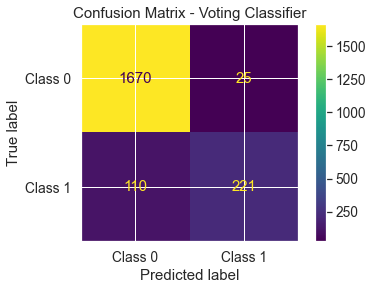

In [128]:
plt.figure(figsize=(6, 4))
eclf.fit(X_train, y_train)
plot_confusion_matrix(eclf, X_val, y_val, display_labels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Voting Classifier')
plt.show()

In [133]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

y_pr_test = eclf.predict(X_val)
acc_test = accuracy_score(y_val, y_pr_test)
class_re1 = classification_report(y_val,y_pr_test)
con_mat1 = confusion_matrix(y_val,y_pr_test)
balanced_accuracy = balanced_accuracy_score(y_val, y_pr_test)
print("Test confusion Matrix:\n",con_mat1)
print("\n")
print("Test accuracy of the model:",(acc_test)*100)
print("Test balanced accuracy of the model:", balanced_accuracy)
print("\n")
print("Test classification report:\n",class_re1)

Test confusion Matrix:
 [[1670   25]
 [ 110  221]]


Test accuracy of the model: 93.33662388943732
Test balanced accuracy of the model: 0.8264622267376057


Test classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      1695
           1       0.90      0.67      0.77       331

    accuracy                           0.93      2026
   macro avg       0.92      0.83      0.86      2026
weighted avg       0.93      0.93      0.93      2026



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


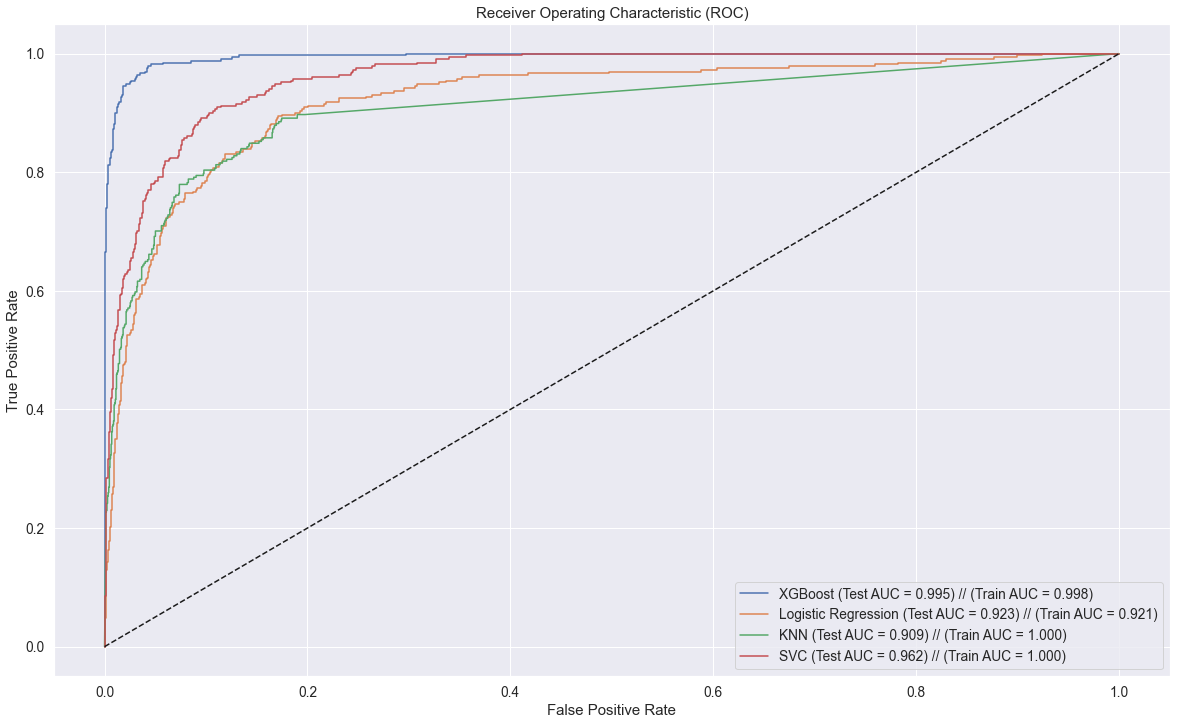

In [138]:
plt.figure(figsize=(20, 12))

classifiers = [clf1, clf2, clf3, clf4]
labels = ['XGBoost', 'Logistic Regression', 'KNN', 'SVC']

for clf, label in zip(classifiers, labels):
    if isinstance(clf, XGBClassifier):
        clf.fit(X_train, y_train)
        y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
        y_val_pred_proba = clf.predict_proba(X_val)[:, 1]
    elif isinstance(clf, LogisticRegression):
        clf.fit(X_train, y_train)
        y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
        y_val_pred_proba = clf.predict_proba(X_val)[:, 1]
    elif isinstance(clf, KNeighborsClassifier):
        clf.fit(X_train, y_train)
        y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
        y_val_pred_proba = clf.predict_proba(X_val)[:, 1]
    elif isinstance(clf, SVC):
        clf.fit(X_train, y_train)
        y_train_pred_proba = clf.decision_function(X_train)
        y_val_pred_proba = clf.decision_function(X_val)
    else:
        continue
    auc_score_train = roc_auc_score(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    auc_score_val = roc_auc_score(y_val, y_val_pred_proba)
    plt.plot(fpr_val, tpr_val, label=f'{label} (Test AUC = {auc_score_val:.3f}) // (Train AUC = {auc_score_train:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
